In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import time

In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/taylor/cloud.data 

--2021-01-21 06:31:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/taylor/cloud.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209266 (204K) [application/x-httpd-php]
Saving to: ‘cloud.data’

cloud.data          100%[===================>] 204.36K   446KB/s    in 0.5s    

2021-01-21 06:31:26 (446 KB/s) - ‘cloud.data’ saved [209266/209266]



In [3]:
cloud = []

with open('cloud.data') as fid:
  for aline in fid:
    aline = aline.strip().split()
    try:
      l = list(map(float,aline))
      if l:
        cloud.append(l)
    except: None

# convert to numpy array
cloud = np.array([np.array(i) for i in cloud])
cloud.shape

(2048, 10)

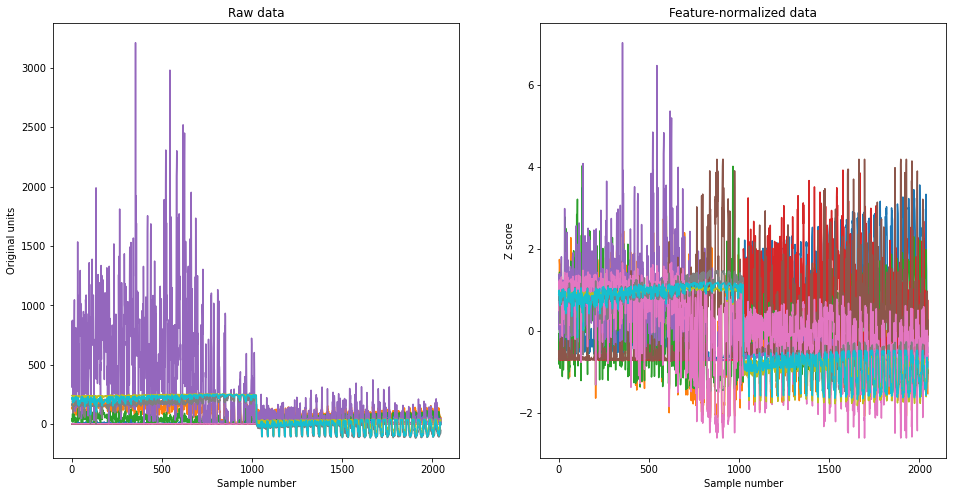

In [4]:
# normalization 

cloudz = np.zeros(cloud.shape)

for coli in range(cloud.shape[1]):
  mean = np.mean(cloud[:,coli])
  std  = np.std(cloud[:,coli])
  cloudz[:,coli] = (cloud[:,coli]-mean)/std


fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(cloud)
ax[0].set_xlabel('Sample number')
ax[0].set_ylabel('Original units')
ax[0].set_title('Raw data')

ax[1].plot(cloudz)
ax[1].set_xlabel('Sample number')
ax[1].set_ylabel('Z score')
ax[1].set_title('Feature-normalized data')
plt.show()


# Covariance matrices


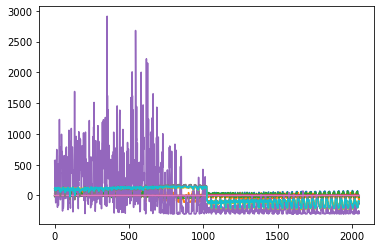

In [5]:
# mean-center
cloud_demean = cloud - cloud.mean(axis=0)

plt.plot(cloud_demean)
plt.show()

In [6]:
# covariances for features
cov_features  = cloud_demean.T@cloud_demean / cloud_demean.shape[1]
cov_featuresZ = cloudz.T@cloudz / cloud.shape[1]

# covariances for observations
cov_observations  = cloud_demean@cloud_demean.T   / cloud.shape[0]
cov_observationsZ = cloudz@cloudz.T / cloud.shape[0]


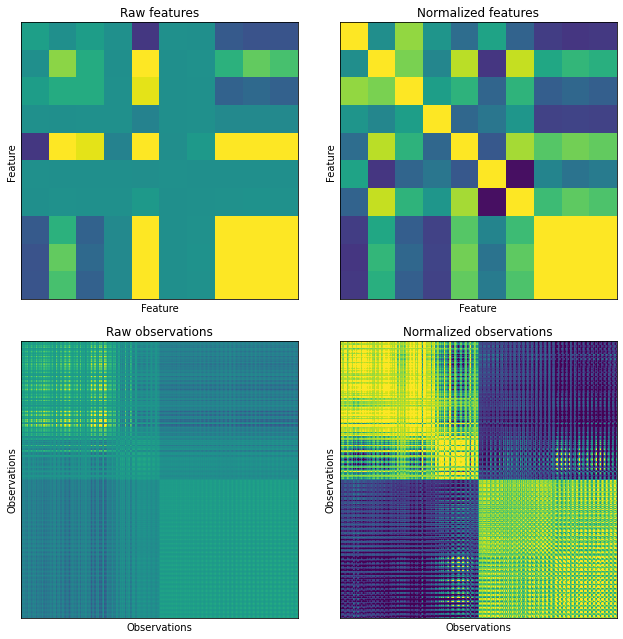

In [15]:
fig,ax = plt.subplots(2,2,figsize=(9,9))
fig.tight_layout()

#covariance matrix
ax[0,0].imshow(cov_features,vmin=-8e5,vmax=8e5)
ax[0,0].set_xlabel('Feature')
ax[0,0].set_ylabel('Feature')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('Raw features')

ax[0,1].imshow(cov_featuresZ,vmin=-200,vmax=200)
ax[0,1].set_xlabel('Feature')
ax[0,1].set_ylabel('Feature')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('Normalized features')


ax[1,0].imshow(cov_observations, vmin=-np.max(abs(cov_observations))*.1,vmax=np.max(abs(cov_observations))*.1)
ax[1,0].set_xlabel('Observations')
ax[1,0].set_ylabel('Observations')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title('Raw observations')

ax[1,1].imshow(cov_observationsZ,vmin=-np.max(abs(cov_observationsZ))*.1,vmax=np.max(abs(cov_observationsZ))*.1)
ax[1,1].set_xlabel('Observations')
ax[1,1].set_ylabel('Observations')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title('Normalized observations')

plt.show()

# Determining the number of components using PCA

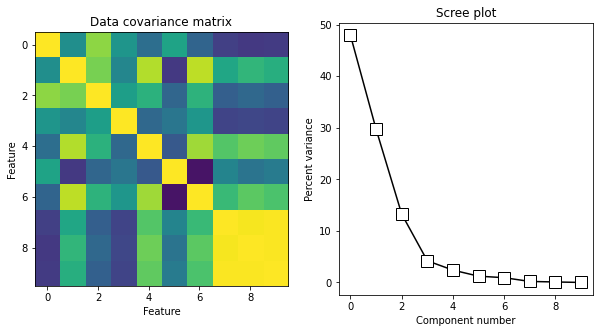

In [16]:
pca = PCA().fit(cloudz)

fig,ax = plt.subplots(1,2,figsize=(10,5))

# covariance matrix
ax[0].imshow(pca.get_covariance(),vmin=-1,vmax=1)
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Feature')
ax[0].set_title('Data covariance matrix')

# scree plot
ax[1].plot(100*pca.explained_variance_ratio_,'ks-',markersize=12,markerfacecolor='w')
ax[1].set_xlabel('Component number')
ax[1].set_ylabel('Percent variance')
ax[1].set_title('Scree plot')
plt.show()


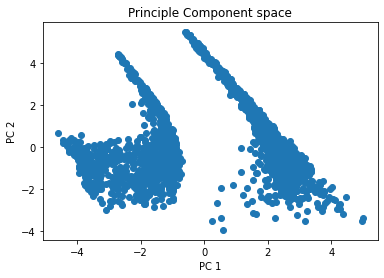

In [17]:
# transformation to get into PC space
cloud2D = pca.transform(cloudz)

plt.plot(cloud2D[:,0],cloud2D[:,1],'o')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Principle Component space')
plt.show()

# Using t-SNE and k-means


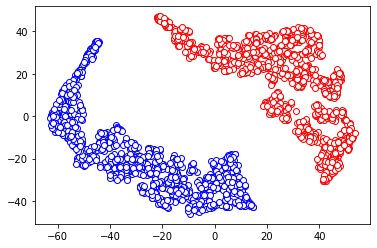

In [18]:
t = TSNE().fit_transform(cloudz)
clusters = KMeans(n_clusters=2).fit(t)

plt.plot(t[clusters.labels_==0,0],t[clusters.labels_==0,1],'bo',markerfacecolor='w')
plt.plot(t[clusters.labels_==1,0],t[clusters.labels_==1,1],'ro',markerfacecolor='w')
plt.show()

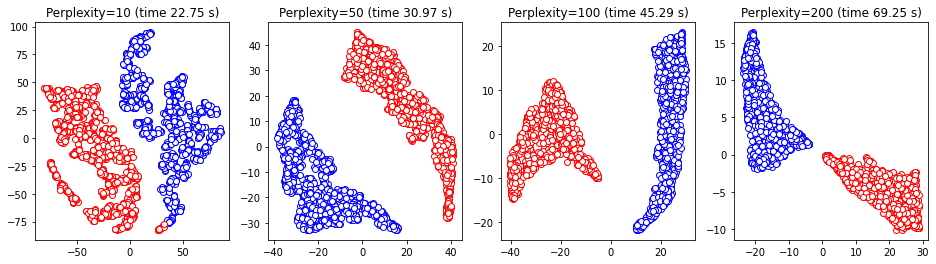

In [19]:
# multiple perplexities for t-SNE
perps = [10,50,100,200]

fig,ax = plt.subplots(1,4,figsize=(16,4))

for i in range(4):
  starttime = time.clock()
  t = TSNE(perplexity=perps[i]).fit_transform(cloudz) 
  
  clusters = KMeans(n_clusters=2).fit(t)
  
  ax[i].plot(t[clusters.labels_==0,0],t[clusters.labels_==0,1],'bo',markerfacecolor='w')
  ax[i].plot(t[clusters.labels_==1,0],t[clusters.labels_==1,1],'ro',markerfacecolor='w')
  ax[i].set_title('Perplexity=%s (time %.2f s)'%(perps[i],time.clock()-starttime))


In [20]:
print(f'Perpexity={perps[2]} (time {time.clock()-starttime:.2f} seconds)')

Perpexity=100 (time 70.55 seconds)


# 2D likelihood density plot

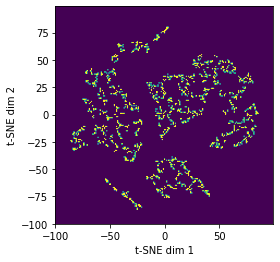

In [23]:
# decomposition re-run
t = TSNE(perplexity=10).fit_transform(cloudz)

trange = np.arange(-100,100)
timage = np.zeros((len(trange),len(trange)))

for i in range(len(t)):
  xi = np.argmin((t[i,0]-trange)**2)
  yi = np.argmin((t[i,1]-trange)**2)
  timage[yi,xi] += 1

plt.imshow(timage,vmin=0,vmax=1,origin='top',extent=[trange[0],trange[-1],trange[0],trange[-1]])
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')

#plt.plot(t[:,0],t[:,1],'w.',markersize=3)
plt.show()

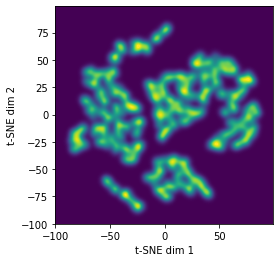

In [24]:
# smoothing the image using scipy.ndimage
from scipy.ndimage import gaussian_filter

# Gaussian filter
timage_smooth = gaussian_filter(timage,sigma=(3,3))

plt.imshow(timage_smooth,vmin=0,vmax=.3,origin='top',extent=[trange[0],trange[-1],trange[0],trange[-1]])
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.show()